The following code was adapted from the following sites: 

-> https://www.youtube.com/watch?v=zcq5aw9t-Ds 
-> https://wellsr.com/python/leaf-disease-detection-with-keras-using-convolutional-neural-network/
-> https://github.com/amitjha11/Plant-Disease-Detection-Using-VGG16/blob/master/plant-disease-detection-using-vgg16.ipynb
-> https://github.com/xenon1919/Plant-Disease-Prediction-using-CNN/blob/main/Plant_Disease_Prediction_using_CNN.ipynb
-> https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix


In [22]:
#!unzip Dataset\ 1_Aphids.zip

In [23]:
base_dir = '/content/Dataset 1_Aphids'
cabbage_dir = os.path.join(base_dir, 'Aphids')
healthy_dir = os.path.join(base_dir, 'Healthy Leaves')

BATCH_SIZE = 4
IMG_SIZE = (224, 224)
EPOCHS = 20

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 127 images belonging to 2 classes.
Found 31 images belonging to 2 classes.


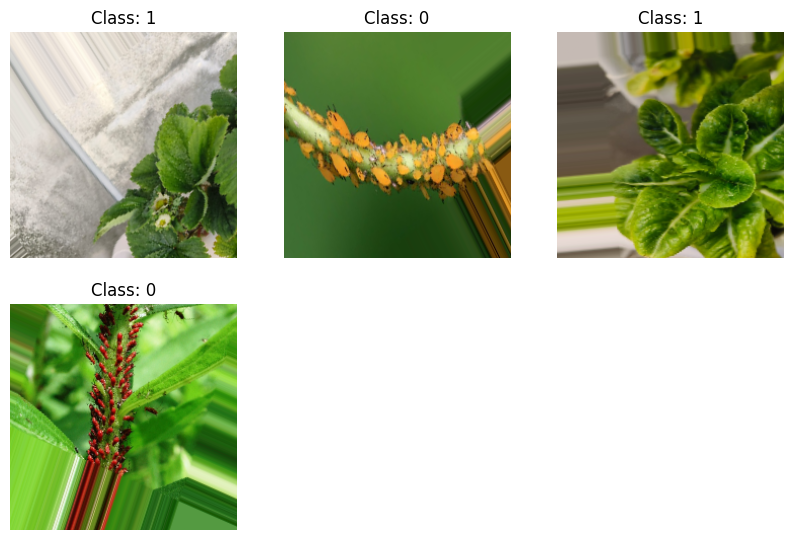

In [25]:
def plot_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Class: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.show()

plot_images(train_generator)

In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
train_steps = max(1, train_generator.samples // BATCH_SIZE)
val_steps = max(1, validation_generator.samples // BATCH_SIZE)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Training samples: 127
Validation samples: 31


In [28]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 311ms/step - accuracy: 0.5858 - loss: 1.0160 - val_accuracy: 0.5714 - val_loss: 0.6905
Epoch 2/20
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5000 - loss: 0.7272

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5000 - loss: 0.7272 - val_accuracy: 0.0000e+00 - val_loss: 1.3713
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 244ms/step - accuracy: 0.7704 - loss: 0.5603 - val_accuracy: 0.8571 - val_loss: 0.4252
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.2298 - val_accuracy: 0.6667 - val_loss: 0.7025
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.7604 - loss: 0.5252 - val_accuracy: 0.6071 - val_loss: 0.5104
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.2426 - val_accuracy: 0.3333 - val_loss: 2.2743


In [29]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes

class_labels = list(validation_generator.class_indices.keys())

report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step
                precision    recall  f1-score   support

        Aphids       1.00      0.62      0.77        16
Healthy Leaves       0.71      1.00      0.83        15

      accuracy                           0.81        31
     macro avg       0.86      0.81      0.80        31
  weighted avg       0.86      0.81      0.80        31



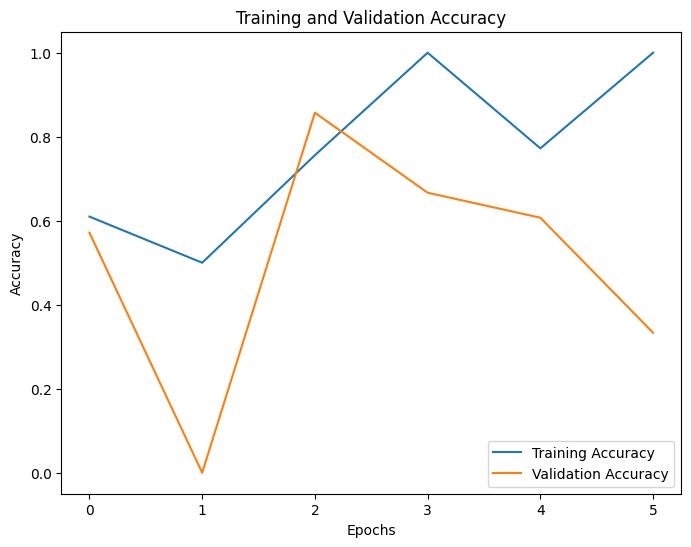

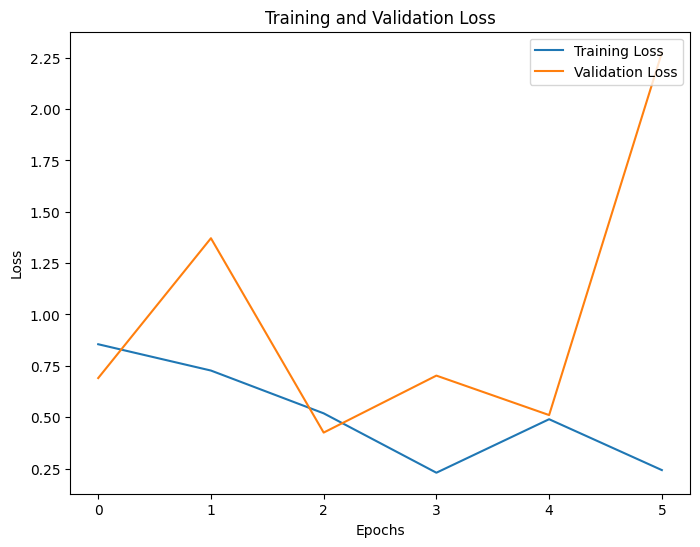

In [30]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(accuracy))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()


In [32]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    x = img_to_array(img)
    x = x.astype('float32') / 255.
    x = np.expand_dims(x, axis=0)
    return x

image_path = '/content/Dataset 1_Aphids/Aphids/Image_100.jpg'

x = preprocess_image(image_path, target_size=IMG_SIZE)

y_pred = model.predict(x)
predicted_index = np.argmax(y_pred, axis=1)[0]

class_labels = list(validation_generator.class_indices.keys())
predicted_label = class_labels[predicted_index]

print(f"Predicted label: {predicted_label}")
print(f"Prediction confidence: {y_pred[0][predicted_index] * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted label: Aphids
Prediction confidence: 76.24%


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 351ms/step


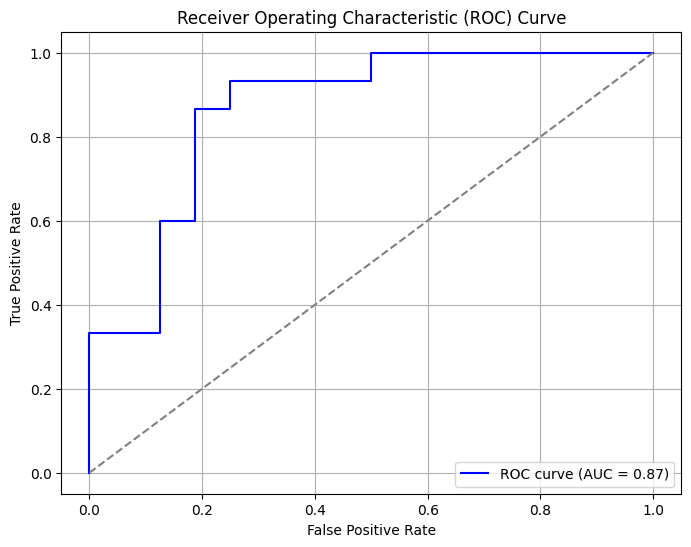

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_prob = model.predict(validation_generator)

y_true = validation_generator.classes
y_pred_positive_class = y_pred_prob[:, 1]  

fpr, tpr, thresholds = roc_curve(y_true, y_pred_positive_class)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


The inital dataset 

train test was 20 80 

leanring rate was 0.0001